# Get Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0 nilearn==0.10.0
!pip install kds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 88.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 82.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: nilearn
    Found existing installation: nilearn 0.11.1
    Uninstalling nilearn-0.11.1:
      Successfully uninstalled nilearn-0.11.1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_validate
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
import shap
import kds
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, recall_score, roc_auc_score, precision_score, accuracy_score

In [5]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [6]:
df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_s = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

In [7]:
df_test = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

In [ ]:
df.shape, df_s.shape, df_test.shape

In [ ]:
df.head(10)

In [ ]:
df_s.head(10)

In [ ]:
df.isna().sum()

In [ ]:
num_duplicates = df_s.duplicated(subset='TransactionID').sum()
print(f"Number of duplicate TransactionIDs: {num_duplicates}")

In [ ]:
df['isFraud'].value_counts()

# Cleaning

In [7]:
def get_cat_cols(df):
    return df.select_dtypes(include=['object', 'category']).columns

def get_num_cols(df):
    return df.select_dtypes(include=['int64','float64', 'number']).columns

In [ ]:
cols_to_remove=df.columns[df.isna().mean() > 0.7]
row_nan_frac=0.5
num_imputer=SimpleImputer(strategy='mean')
cat_imputer=SimpleImputer(strategy='most_frequent')
outlier_handling='iqr'
outlier_thresh=0.1

In [8]:
def clean(df,
          cols_to_remove=df.columns[df.isna().mean() > 0.7],
          row_nan_frac=0.5,
          num_imputer=SimpleImputer(strategy='mean'),
          cat_imputer=SimpleImputer(strategy='most_frequent'),
          outlier_handling='iqr',
          outlier_thresh=0.25):
    # drop useless cols
    df_pre = df.drop(columns=cols_to_remove, errors='ignore')

    # drop useless rows
    df_pre.dropna(axis=0, thresh=int(df_pre.shape[1] * (1 - row_nan_frac)), inplace=True)

    # impute
    num_cols = get_num_cols(df_pre)
    cat_cols = get_cat_cols(df_pre)
    imputer = ColumnTransformer(
        transformers=[
            ('num', num_imputer, num_cols),
            ('cat', cat_imputer, cat_cols)
        ]
    )
    imputer.fit(df_pre)
    cols = num_cols.tolist()+cat_cols.tolist()
    df_pre = pd.DataFrame(imputer.transform(df_pre), columns=cols)
    df_pre[num_cols] = df_pre[num_cols].astype('float64')
    df_pre[cat_cols] = df_pre[cat_cols].astype('object')
        
    # remove outliers
    majority = df_pre[df_pre['isFraud'] == 0]
    minority = df_pre[df_pre['isFraud'] == 1]
    if outlier_handling == 'zscore':
        z_scores = np.abs(zscore(majority[num_cols]))
        majority = majority[(z_scores < outlier_thresh).all(axis=1)]
    elif outlier_handling == 'iqr':
        Q1 = majority[num_cols].quantile(outlier_thresh)
        Q3 = majority[num_cols].quantile(1 - outlier_thresh)
        IQR = Q3 - Q1

        majority = majority[~((majority[num_cols] < (Q1 - 1.5 * IQR)) | (majority[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

    df_pre = pd.concat([majority, minority])
    
    return df_pre

In [ ]:
df_cleaned = clean(df, outlier_handling=outlier_handling, outlier_thresh=outlier_thresh)
df_cleaned.head(10)

In [ ]:
df_cleaned.shape

In [ ]:
df_cleaned['isFraud'].value_counts()

In [ ]:
X = df_cleaned.drop(columns=['isFraud'])
X.head(10)

In [ ]:
y = df_cleaned['isFraud']
y.head(10)

In [9]:
class CleaningPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 cols_to_remove=[],
                 num_imputer=SimpleImputer(strategy='median'), 
                 cat_imputer=SimpleImputer(strategy='constant', fill_value='missing')):
        self.cols_to_remove = cols_to_remove
        self.num_imputer = num_imputer
        self.cat_imputer = cat_imputer
    
    def fit(self, X, y=None):
        X_clean = X.drop(columns=self.cols_to_remove, errors='ignore')

        self.num_cols = get_num_cols(X_clean)
        self.cat_cols = get_cat_cols(X_clean)
        
        self.imputer = ColumnTransformer(
            transformers=[
                ('num', self.num_imputer, self.num_cols),
                ('cat', self.cat_imputer, self.cat_cols)
            ]
        )
        
        self.imputer.fit(X_clean)
        return self
    
    def transform(self, X):
        
        X_clean = X.copy()

        # drop useless cols
        X_clean.drop(columns=self.cols_to_remove, errors='ignore', inplace=True)

        # impute
        cols = self.num_cols.tolist()+self.cat_cols.tolist()
        X_clean = pd.DataFrame(self.imputer.transform(X_clean), columns=cols)
        X_clean[self.num_cols] = X_clean[self.num_cols].astype('float64')
        X_clean[self.cat_cols] = X_clean[self.cat_cols].astype('object')
        
        return X_clean

In [ ]:
cleaner = CleaningPreprocessor(cols_to_remove=cols_to_remove, num_imputer=num_imputer, cat_imputer=cat_imputer)

In [ ]:
cleaned = cleaner.fit_transform(X, y)
cleaned.shape

In [ ]:
cleaned_test = cleaner.transform(df_test)
cleaned_test.shape

In [ ]:
cleaned.head(10)

In [ ]:
cleaned.dtypes

In [ ]:
cleaned_test.isna().sum()

# Feature Engineering

In [10]:
class FeatureEngineeringPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, encoding):
        self.encoding = encoding
    
    def fit(self, X, y):
        x_tmp = pd.concat([X, y], axis=1)
        self.cat_cols = get_cat_cols(X)
        if self.encoding == 'target':
            self.target_mean_map = {}
            for col in self.cat_cols:
                self.target_mean_map[col] = x_tmp.groupby(col)[y.name].mean()
        elif self.encoding == 'frequency':
            self.frequency_map = {}
            for col in self.cat_cols:
                self.frequency_map[col] = X[col].value_counts(normalize=True)
        elif self.encoding == 'woe':
            self.woe_map = {}
            for col in self.cat_cols:
                groups = x_tmp.groupby([col])['isFraud'].agg(['count', 'sum'])
                groups.columns = ['n_obs', 'n_pos']
                groups['n_neg'] = groups['n_obs'] - groups['n_pos']
        
                groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
                groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()

                epsilon = 1e-6
                groups['woe'] = np.log(groups['prop_pos']+epsilon/ groups['prop_neg']+epsilon)
        
                groups.replace([np.inf, -np.inf], 0, inplace=True)
                groups.fillna(0, inplace=True)
            
                woe_dict = groups['woe'].to_dict()
            
                self.woe_map[col] = woe_dict
        return self
    
    def transform(self, X):
        modified = set()
        X_transformed = X.copy()
        
        if self.encoding == 'one_hot':
            one_hot_encoded = X_transformed = pd.get_dummies(X_transformed, columns=self.cat_cols, drop_first=True)
        elif self.encoding == 'target':
            for col in self.cat_cols:
                X_transformed[col] = X_transformed[col].map(self.target_mean_map[col])
        elif self.encoding == 'frequency':
            for col in self.cat_cols:
                X_transformed[col] = X_transformed[col].map(self.frequency_map[col])
        elif self.encoding == 'woe':
            for col in self.cat_cols:
                X_transformed[col] = X_transformed[col].map(self.woe_map[col])
        else:
            encoder = LabelEncoder()
            for col in self.cat_cols:
                X_transformed[col] = encoder.fit_transform(X_transformed[col])

        X_transformed = X_transformed.fillna(0)
        return X_transformed

In [ ]:
cleaned_cat_cols = get_cat_cols(cleaned)
cleaned_cat_cols

In [ ]:
engineer = FeatureEngineeringPreprocessor(woe_cats=cleaned_cat_cols)

In [ ]:
engineered = engineer.fit_transform(cleaned, y)
engineered.head(10)

In [ ]:
engineered_test = engineer.transform(cleaned_test)
engineered_test.head(10)

# Feature Selection

In [11]:
def correlation_filter(X, y, threshold=0.8, log=False):
    corr = X.drop(columns=['TransactionID']).corr().abs()

    to_drop_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if corr.iloc[i, j] > threshold:
                to_drop_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))

    if log:
        print("Highly correlated pairs:")
        for col1, col2, corr_val in to_drop_pairs:
            print(f"{col1} and {col2}: {corr_val}")
        
    to_drop = set()
    for col1, col2, _ in to_drop_pairs:
        if abs(X[col1].corr(y)) > abs(X[col2].corr(y)):
            to_drop.add(col2)
        else:
            to_drop.add(col1)
            
    to_drop = list(to_drop)
    if log:
        print(f"Columns to drop: {to_drop}")
    
    return to_drop


def rfe_feature_selection(X, y, model, n_features_to_select=30, log=False):
    # Drop 'TransactionID' if present
    X_t = X.drop(columns=['TransactionID'], errors='ignore')
    
    # Initialize and fit RFE
    selector = RFE(model, n_features_to_select=n_features_to_select, step=1)
    selector.fit(X_t, y)
    
    # Create DataFrame of selected features
    selected_df = pd.DataFrame({
        'feature': X_t.columns,
        'selected': selector.support_,
        'ranking': selector.ranking_
    }).sort_values(by='selected', ascending=False).reset_index(drop=True)
    
    if log:
        selected_list = selected_df[selected_df['selected']]['feature'].tolist()
        print(f"Selected features: {selected_list}")
    
    return selected_df


def shap_feature_importance(model, X):
    # Initialize SHAP explainer (TreeExplainer for tree-based models)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # If multiclass, shap_values is a list or array with shape (num_classes, n_samples, n_features)
    if isinstance(shap_values, list):
        shap_values = np.stack(shap_values, axis=0)

    # Take mean absolute shap value across classes and samples
    shap_importance = np.abs(shap_values).mean(axis=(0, 1))

    shap_df = pd.DataFrame({
        'feature': X.columns,
        'importance': shap_importance
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    return shap_df


def model_feature_importance(model, X):
    # Extract feature importances from the model
    importances = model.feature_importances_
    
    # Create DataFrame with feature importances
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    return importance_df


In [12]:
class FeatureSelectionPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features=None):
        self.selected_features = selected_features
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        if self.selected_features is not None:
            for col in self.selected_features:
                if col not in X_transformed.columns:
                    X_transformed[col] = False
            return X_transformed[self.selected_features]
        return X_transformed

In [ ]:
to_drop_corr = correlation_filter(engineered, y, log=True)
dropped_corr = engineered.drop(columns=to_drop_corr)
to_stay_rfe = rfe(dropped_corr, y, log=True)

In [ ]:
selector = FeatureSelectionPreprocessor(selected_features=to_stay_rfe)

In [ ]:
selected = selector.fit_transform(engineered, y)
selected.head(10)

# Training

In [13]:
# cleaning

cols_to_remove=df.columns[df.isna().mean() > 0.5]
row_nan_frac=0.5
num_imputer=SimpleImputer(strategy='mean')
cat_imputer=SimpleImputer(strategy='most_frequent')
outlier_handling='none'
outlier_thresh=0.1

df_cleaned = clean(df, 
                   cols_to_remove=cols_to_remove, 
                   row_nan_frac=row_nan_frac,
                   num_imputer=num_imputer,
                   cat_imputer=cat_imputer,
                   outlier_handling=outlier_handling, 
                   outlier_thresh=outlier_thresh)
X = df_cleaned.drop(columns=['isFraud'])
y = df_cleaned['isFraud']
cleaner = CleaningPreprocessor(cols_to_remove=cols_to_remove, 
                               num_imputer=num_imputer, 
                               cat_imputer=cat_imputer)
cleaned = cleaner.fit_transform(X, y)
print('cleaned')

cleaned


In [ ]:
cleaned.shape

In [ ]:
y.value_counts()

In [14]:
# engineering

encoding='one_hot'
engineer = FeatureEngineeringPreprocessor(encoding=encoding)
engineered = engineer.fit_transform(X, y)
print('engineered')

engineered


In [15]:
# selecting

corr_threshold = 0.8

to_drop_corr = correlation_filter(engineered, y, threshold=corr_threshold, log=True)
selected = engineered.drop(columns=to_drop_corr)
print('selected (dropped)')

Highly correlated pairs:
C2 and C1: 0.9950922265975789
C4 and C1: 0.9678191450801629
C4 and C2: 0.9721683685989218
C6 and C1: 0.9822644098898683
C6 and C2: 0.9748799452962646
C6 and C4: 0.9622870266344012
C7 and C1: 0.926453560690114
C7 and C2: 0.9390523410888787
C7 and C4: 0.8954804876796856
C7 and C6: 0.8589508876210122
C8 and C1: 0.9677808071033681
C8 and C2: 0.9758976622250058
C8 and C4: 0.9601410514138992
C8 and C6: 0.9220955042337347
C8 and C7: 0.9830458297299794
C9 and C5: 0.9257855428353142
C10 and C1: 0.9582434265005132
C10 and C2: 0.9706624494762316
C10 and C4: 0.9526259389876505
C10 and C6: 0.9145783408945913
C10 and C7: 0.9851145588877714
C10 and C8: 0.9969706004899238
C11 and C1: 0.996517355975288
C11 and C2: 0.9939048166706655
C11 and C4: 0.9745470557188236
C11 and C6: 0.9911159410470871
C11 and C7: 0.9154598146020854
C11 and C8: 0.962783340926507
C11 and C10: 0.9561266792835369
C12 and C1: 0.9281356723190011
C12 and C2: 0.9404422762462694
C12 and C4: 0.8950068199397686
C

In [ ]:
selected = engineered.drop(columns=to_drop_corr)

In [ ]:
# feature importance
ranked_features_df = model_feature_importance(model, sampled)

In [20]:
# shap
ranked_features_df = shap_feature_importance(model, sampled)

In [21]:
ranked_features_df.head(10)

,feature,importance
0,C9,0.102363
1,V287,0.050523
2,V40,0.044257
3,TransactionAmt,0.029672
4,V17,0.029077
5,TransactionDT,0.028668
6,D3,0.027061
7,D1,0.020927
8,V86,0.016778
9,V283,0.013075


In [22]:
# selecting (feature importance or shap)
n_features_to_select = 30
to_stay = ranked_features_df[:n_features_to_select]['feature']

selector = FeatureSelectionPreprocessor(selected_features=to_stay)
selected = selector.fit_transform(engineered, y)
print('selected')

selected


In [ ]:
# sampling

sampler = SMOTE(random_state=42)
sampled, sampled_y = sampler.fit_resample(selected, y)
print('sampled')

In [23]:
# no sampling

sampler = None
sampled = selected
sampled_y = y
print('not sampled')

not sampled


In [55]:
# model

model = DecisionTreeClassifier(
    criterion='entropy',           # 'entropy' for information gain, 'gini' for Gini impurity
    splitter='best',              # or 'random' (best is usually preferred)
    max_depth=None,              # limit tree depth (controls overfitting)
    min_samples_split=2,         # minimum samples to split an internal node
    min_samples_leaf=1,          # minimum samples at a leaf node (prevents overly deep branches)
    max_features='sqrt',         # number of features to consider at each split ('auto', 'log2', or int/float)
    max_leaf_nodes=None,           # limits number of leaf nodes
    min_weight_fraction_leaf=0.0, # fraction of weighted samples required at a leaf node
    class_weight='balanced',     # automatically balances class weights (important for imbalanced data)
    ccp_alpha=0,             # complexity parameter for Minimal Cost-Complexity Pruning
    random_state=42              # ensures reproducibility
)

modeled = model.fit(sampled, sampled_y)
print('modeled')

modeled


## Evaluate

In [56]:
full_pipe = ImbPipeline([
    ('cleaner', cleaner),
    ('engineer', engineer),
    ('selector', selector),
    ('sampler', sampler),
    ('model', model)
])

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring = {
    'f1_macro': 'f1_macro',
    'recall_macro': 'recall_macro',
    'roc_auc': 'roc_auc',
    'precision_macro': 'precision_macro',
    'accuracy': 'accuracy'
}

In [44]:
def evaluate_model(full_pipe, X, y, cv=3):
    # Stratified K-fold
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Initialize variables to store results
    train_f1_scores = []
    train_recall_scores = []
    train_roc_auc_scores = []
    train_precision_scores = []
    train_accuracy_scores = []
    
    test_f1_scores = []
    test_recall_scores = []
    test_roc_auc_scores = []
    test_precision_scores = []
    test_accuracy_scores = []
    
    y_true_all = []
    y_pred_all = []
    y_proba_all = []

    # Loop over each fold
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        full_pipe.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred_test = full_pipe.predict(X_test)
        y_proba_test = full_pipe.predict_proba(X_test)[:, 1]  # Probability for class 1
        
        # Predict on the training set
        y_pred_train = full_pipe.predict(X_train)
        y_proba_train = full_pipe.predict_proba(X_train)[:, 1]  # Probability for class 1

        # Collect true values, predictions, and probabilities
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred_test)
        y_proba_all.extend(y_proba_test)

        # Calculate the evaluation metrics for this fold on the test set
        f1_test = f1_score(y_test, y_pred_test, average='macro')
        recall_test = recall_score(y_test, y_pred_test, average='macro')
        roc_auc_test = roc_auc_score(y_test, y_proba_test)
        precision_test = precision_score(y_test, y_pred_test, average='macro')
        accuracy_test = accuracy_score(y_test, y_pred_test)

        # Calculate the evaluation metrics for this fold on the training set
        f1_train = f1_score(y_train, y_pred_train, average='macro')
        recall_train = recall_score(y_train, y_pred_train, average='macro')
        roc_auc_train = roc_auc_score(y_train, y_proba_train)
        precision_train = precision_score(y_train, y_pred_train, average='macro')
        accuracy_train = accuracy_score(y_train, y_pred_train)

        # Store the results
        train_f1_scores.append(f1_train)
        train_recall_scores.append(recall_train)
        train_roc_auc_scores.append(roc_auc_train)
        train_precision_scores.append(precision_train)
        train_accuracy_scores.append(accuracy_train)

        test_f1_scores.append(f1_test)
        test_recall_scores.append(recall_test)
        test_roc_auc_scores.append(roc_auc_test)
        test_precision_scores.append(precision_test)
        test_accuracy_scores.append(accuracy_test)

    # Print cross-validation scores for training
    print("Training Scores:")
    print(f"F1 Macro: {np.mean(train_f1_scores):.4f}")
    print(f"Recall Macro: {np.mean(train_recall_scores):.4f}")
    print(f"ROC AUC: {np.mean(train_roc_auc_scores):.4f}")
    print(f"Precision Macro: {np.mean(train_precision_scores):.4f}")
    print(f"Accuracy: {np.mean(train_accuracy_scores):.4f}")
    
    # Print cross-validation scores for testing
    print("\nTesting Scores:")
    print(f"F1 Macro: {np.mean(test_f1_scores):.4f}")
    print(f"Recall Macro: {np.mean(test_recall_scores):.4f}")
    print(f"ROC AUC: {np.mean(test_roc_auc_scores):.4f}")
    print(f"Precision Macro: {np.mean(test_precision_scores):.4f}")
    print(f"Accuracy: {np.mean(test_accuracy_scores):.4f}")

    # Return scores as a dictionary
    scores_map = {
        'train_f1_macro': np.mean(train_f1_scores),
        'train_recall_macro': np.mean(train_recall_scores),
        'train_roc_auc': np.mean(train_roc_auc_scores),
        'train_precision_macro': np.mean(train_precision_scores),
        'train_accuracy': np.mean(train_accuracy_scores),
        
        'test_f1_macro': np.mean(test_f1_scores),
        'test_recall_macro': np.mean(test_recall_scores),
        'test_roc_auc': np.mean(test_roc_auc_scores),
        'test_precision_macro': np.mean(test_precision_scores),
        'test_accuracy': np.mean(test_accuracy_scores)
    }
    
    return y_true_all, y_pred_all, y_proba_all, scores_map

In [57]:
y_true_all, y_pred_all, y_proba_all, scores = evaluate_model(full_pipe, X, y, cv=3)

Training Scores:
F1 Macro: 1.0000
Recall Macro: 1.0000
ROC AUC: 1.0000
Precision Macro: 1.0000
Accuracy: 1.0000

Testing Scores:
F1 Macro: 0.7413
Recall Macro: 0.7391
ROC AUC: 0.7391
Precision Macro: 0.7436
Accuracy: 0.9654


# Graphs

In [58]:
def tree_vis(model, cols):
    plt.figure(figsize=(16, 6))
    plot_tree(model, feature_names=cols, filled=True, rounded=True, max_depth=4)
    plt.title("Decision Tree Visualization")
    plt.savefig("decision_tree.png", dpi=300, bbox_inches='tight')
    plt.show()

def feat_imp(modeled, cols):
    importances = modeled.feature_importances_

    feature_names = cols

    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    top_features = feat_imp_df['Feature'].tolist()

    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp_df['Feature'][:20][::-1], feat_imp_df['Importance'][:20][::-1])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances (Decision Tree)')
    plt.tight_layout()
    plt.savefig("top_20_feature_importances.png", dpi=300, bbox_inches='tight')
    plt.show()

def shap_g(model, selected):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(selected)
    shap.summary_plot(shap_values, selected, show=False)
    plt.gcf().tight_layout()  # Clean layout
    plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')  # Save
    plt.show()  # Now display the plot
    plt.close()  # Close after display

def conf_mat(y_true_all, y_pred_all, labels=None):
    cm = confusion_matrix(y_true_all, y_pred_all, labels=labels)

    print("\nConfusion Matrix:")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

def roc(y_true_all, y_proba_all):
    fpr, tpr, _ = roc_curve(y_true_all, y_proba_all)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig("roc.png", dpi=300, bbox_inches='tight')
    plt.show()

def prec_rec(y_true_all, y_proba_all):
    precision, recall, _ = precision_recall_curve(y_true_all, y_proba_all)
    avg_precision = average_precision_score(y_true_all, y_proba_all)
    print(f"Average Precision: {avg_precision:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='b', label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.savefig("precision_recall_plot.png", dpi=300, bbox_inches='tight')
    plt.show()

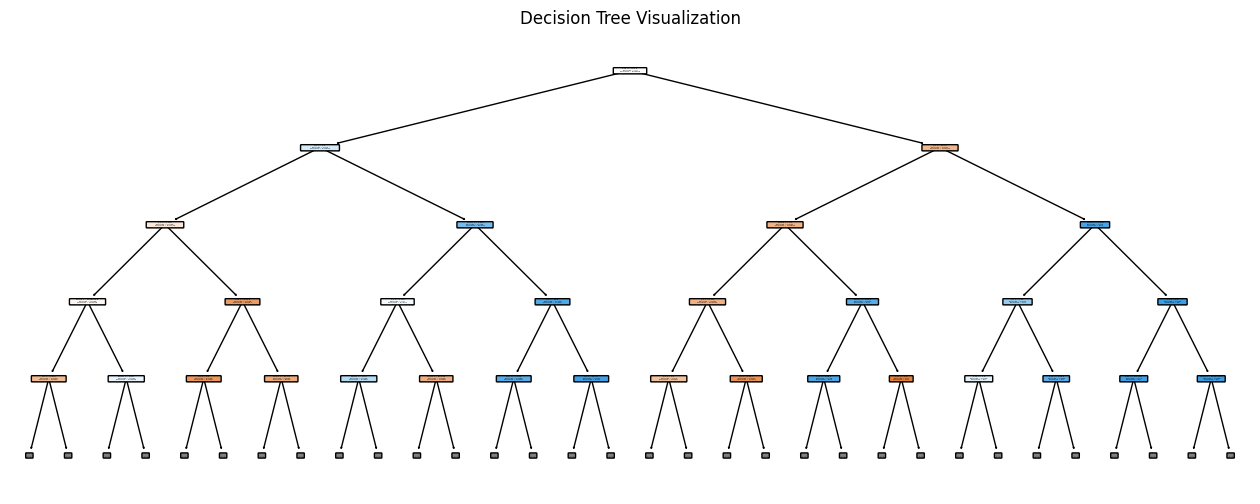

In [59]:
tree_vis(model, X.columns)

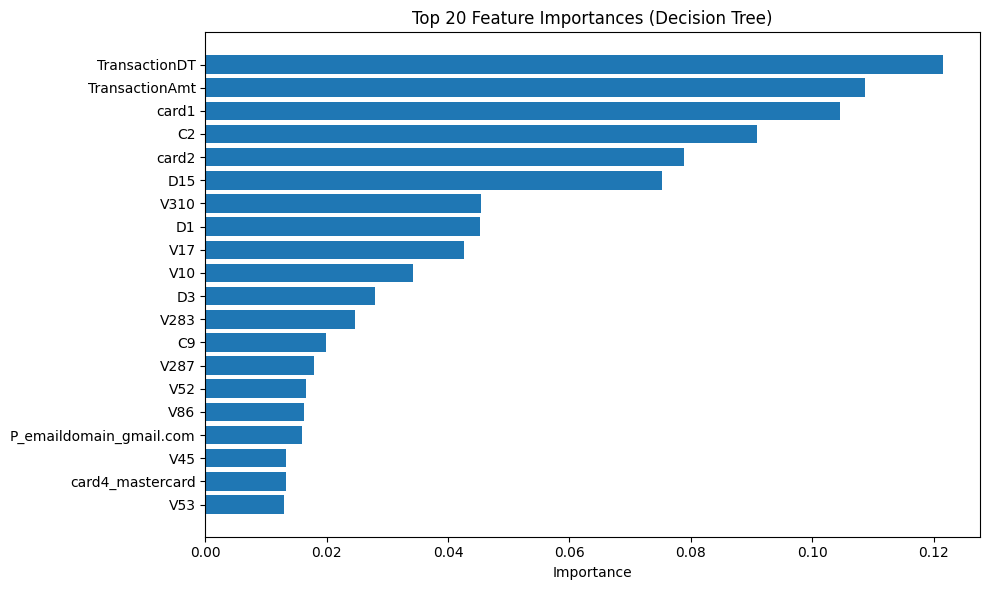

In [60]:
feat_imp(modeled, selected.columns)

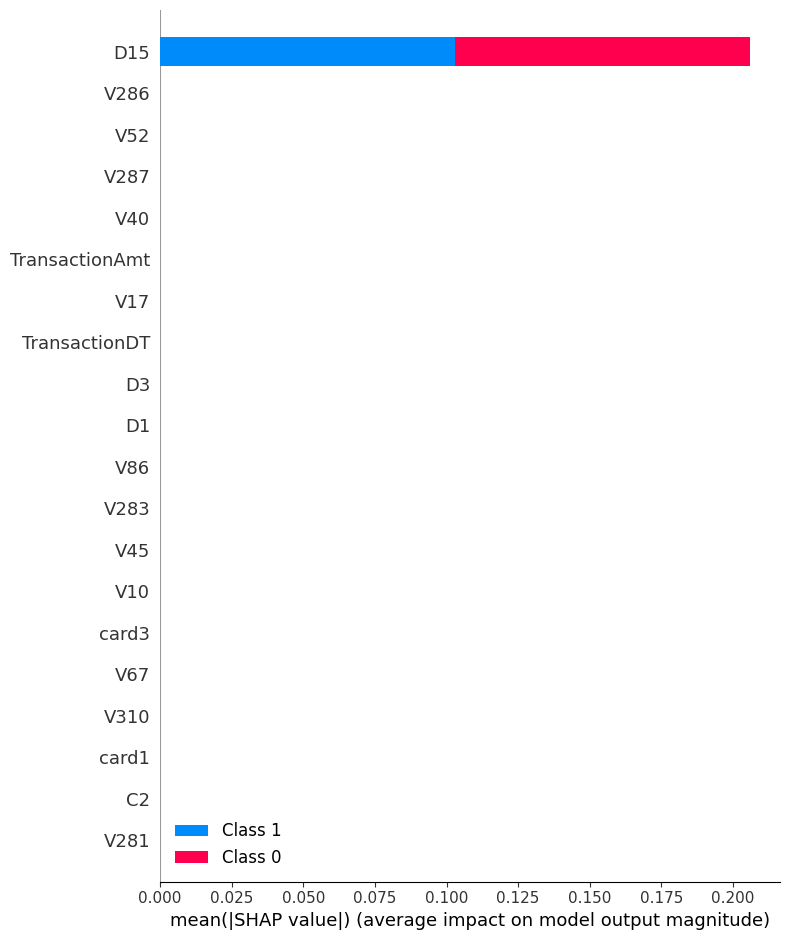

In [37]:
shap_g(model, selected)


Confusion Matrix:


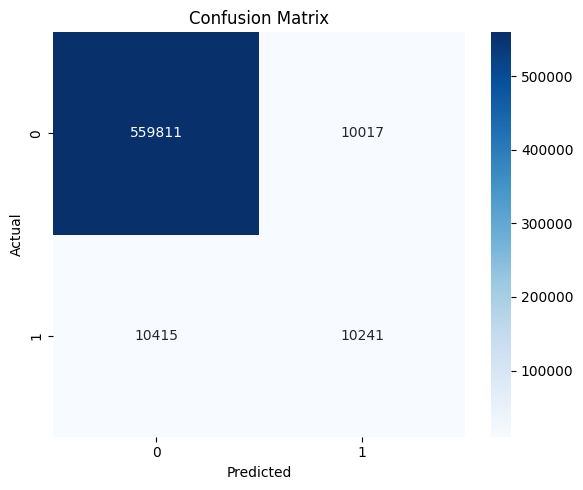

In [61]:
conf_mat(y_true_all, y_pred_all)

ROC AUC: 0.7391


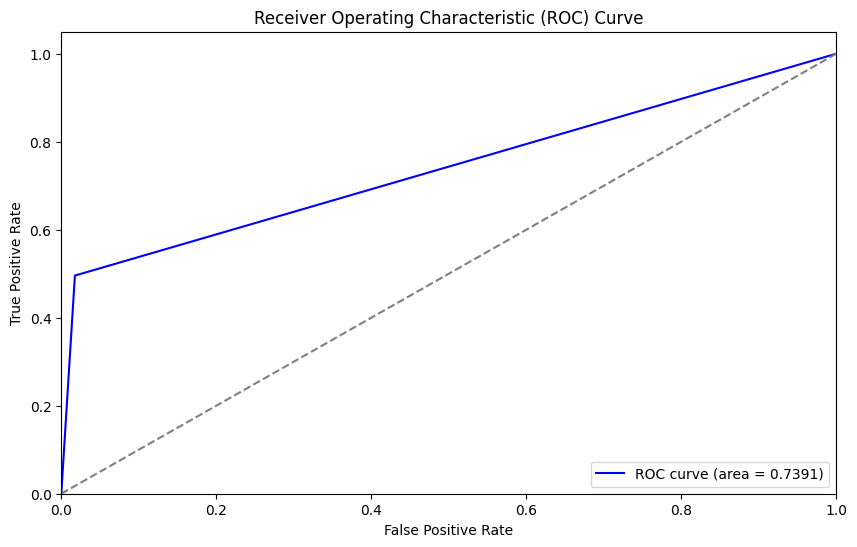

In [62]:
roc(y_true_all, y_proba_all)

Average Precision: 0.2683


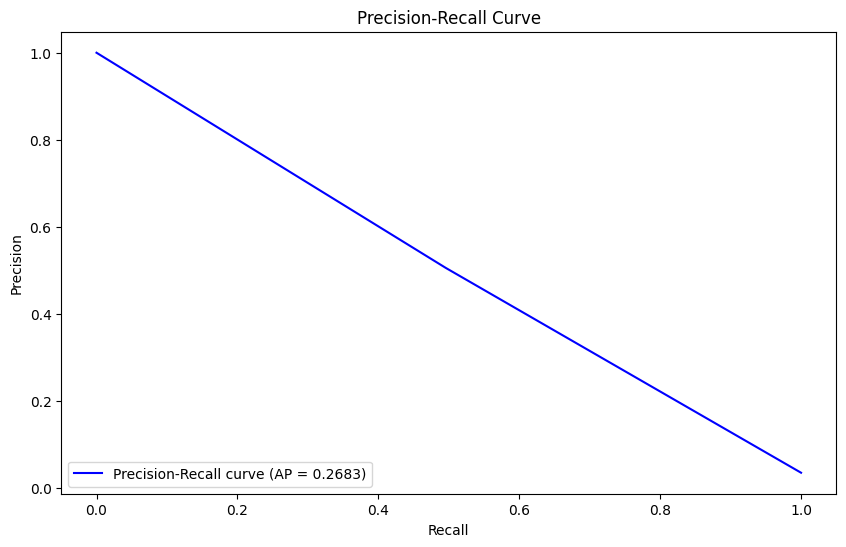

In [63]:
prec_rec(y_true_all, y_proba_all)

# Random Search

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split

def randfloat(low, high):
    return uniform(loc=low, scale=high - low)

X_small, _, y_small, _ = train_test_split(
    X, y,
    test_size=0.5,         
    stratify=y,            # keeps class distribution
    random_state=42        # reproducibility
)


# Define parameter distributions
param_distributions = {
    # 'sampler': [None, SMOTE(random_state=42)],
    'model__max_depth': randint(5, 15),
    'model__min_samples_split': randint(5, 50),
    'model__min_samples_leaf': randint(2, 20),
    'model__max_leaf_nodes': randint(50, 200),
    'model__ccp_alpha': randfloat(0.000, 0.001)
}

# Set up randomized search
random_search = RandomizedSearchCV(
    estimator=full_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='roc_auc',
    cv=skf,
    random_state=42,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Run it
random_search.fit(X_small, y_small)

# Best results
print("Best parameters found:")
print(random_search.best_params_)

print("\nBest score:")
print(random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:
{'model__ccp_alpha': 9.997491581800288e-05, 'model__max_depth': 12, 'model__max_leaf_nodes': 166, 'model__min_samples_leaf': 5, 'model__min_samples_split': 44}

Best score:
0.8383953404960064


In [33]:
# Create DataFrame from search results
results_df = pd.DataFrame(random_search.cv_results_)

# Drop split-specific columns
results_df = results_df.drop(columns=[col for col in results_df.columns if col.startswith('split')])

# Sort by rank score
results_df = results_df.sort_values(by='rank_test_score')

results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__ccp_alpha,param_model__max_depth,param_model__max_leaf_nodes,param_model__min_samples_leaf,param_model__min_samples_split,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
1,23.535402,1.242202,5.195794,0.074112,0.0001,12,166,5,44,"{'model__ccp_alpha': 9.997491581800288e-05, 'm...",0.838395,0.001127,1,0.858606,0.000698
4,25.242656,0.829836,5.479598,0.130204,0.000612,13,98,11,32,"{'model__ccp_alpha': 0.000611653160488281, 'mo...",0.834293,0.003206,2,0.841419,0.002036
17,22.562733,0.229078,5.175866,0.148780,0.000358,13,77,8,13,"{'model__ccp_alpha': 0.00035846572854427263, '...",0.832344,0.005216,3,0.841450,0.003121
0,25.243288,0.698874,5.371322,0.219327,0.000375,12,70,8,23,"{'model__ccp_alpha': 0.0003745401188473625, 'm...",0.830624,0.004306,4,0.838740,0.001262
10,22.481570,0.324374,5.197880,0.082198,0.000312,10,103,11,8,"{'model__ccp_alpha': 0.000311711076089411, 'mo...",0.829136,0.003804,5,0.842978,0.001508
15,22.119499,0.312400,5.655002,0.342591,0.000772,12,112,12,21,"{'model__ccp_alpha': 0.0007722447692966575, 'm...",0.828710,0.004073,6,0.835338,0.001978
8,22.072382,0.158887,5.477759,0.302461,0.000241,11,57,16,39,"{'model__ccp_alpha': 0.00024102546602601172, '...",0.826386,0.003769,7,0.832325,0.002023
12,22.401992,0.071215,5.226890,0.090593,0.000895,12,89,17,49,"{'model__ccp_alpha': 0.0008948273504276489, 'm...",0.825790,0.003717,8,0.830523,0.001067
2,21.519149,0.398031,5.141407,0.096723,0.000708,10,102,3,28,"{'model__ccp_alpha': 0.0007080725777960455, 'm...",0.825138,0.004952,9,0.832771,0.000480
3,21.905270,0.105350,5.369207,0.036390,0.000832,10,179,2,16,"{'model__ccp_alpha': 0.0008324426408004218, 'm...",0.823573,0.005386,10,0.829402,0.002252


# Dagshub Upload

In [38]:
!pip install dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      Successfully uninstalled dacite-1.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.


In [39]:
import dagshub
dagshub.init(repo_owner='Cimbir', repo_name='IEEE-CIS_Fraud_Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=1f8adcfc-9540-4295-bcad-aec7b539cfec&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=c6477b250e740ff671a8d4c9e2d6250a3af61fc7651071fc138298c288eb1ad2




Accessing as Cimbir

Initialized MLflow to track repo "Cimbir/IEEE-CIS_Fraud_Detection"

Repository Cimbir/IEEE-CIS_Fraud_Detection initialized!

In [40]:
!pip install mlflow==2.10.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 72.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 41.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 26.1 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.6.1
    Uninstalling importlib_metadata-8.6.1:
      Successfully uninstalled importlib_metadata-8.6.1
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19

In [64]:
import mlflow

mlflow.set_experiment(f'Decision_Tree_Training')

i = 'Overfit'

# with mlflow.start_run(run_name=f'Decision_Tree_Cleaning_{i}') as run:
#     mlflow.log_param('cols_to_remove', cols_to_remove)
#     mlflow.log_param('row_nan_frac', row_nan_frac)
#     mlflow.log_param('num_imputer', num_imputer)
#     mlflow.log_param('cat_imputer', cat_imputer)
#     mlflow.log_param('outlier_handling', outlier_handling)
#     mlflow.log_param('outlier_thresh', outlier_thresh)

# with mlflow.start_run(run_name=f'Decision_Tree_Engineering_{i}') as run:
#     mlflow.log_param('encoding', encoding)

# with mlflow.start_run(run_name=f'Decision_Tree_Selection_{i}') as run:
#     mlflow.log_param('corr_threshold', corr_threshold)
#     mlflow.log_param('n_features_to_select', n_features_to_select)
#     mlflow.log_param('to_stay', to_stay)
#     mlflow.log_param('feature_selection_method', 'shap')
    
with mlflow.start_run(run_name=f'Decision_Tree_Model_{i}') as run:
    mlflow.log_param('sampler', sampler)
    mlflow.log_param('model', model)

    for key, value in scores.items():
        mlflow.log_metric(key, value.mean())

    for param_name, param_value in model.get_params().items():
        mlflow.log_param('best_'+param_name, param_value)

    # mlflow.log_param('model__max_depth', '5-15')
    # mlflow.log_param('model__min_samples_split', '5-50')
    # mlflow.log_param('model__min_samples_leaf', '2-20')
    # mlflow.log_param('model__max_leaf_nodes', '50-200')
    # mlflow.log_param('model__ccp_alpha', '0-0.001')

    mlflow.log_artifact("decision_tree.png", artifact_path='graph')
    mlflow.log_artifact("top_20_feature_importances.png", artifact_path='graph')
    mlflow.log_artifact("shap_summary_plot.png", artifact_path='graph')
    mlflow.log_artifact("roc.png", artifact_path='graph')
    mlflow.log_artifact("precision_recall_plot.png", artifact_path='graph')
    mlflow.log_artifact("confusion_matrix.png", artifact_path='graph')
    
    # mlflow.sklearn.log_model(full_pipe, artifact_path='model', registered_model_name=f'decision_tree_search_best')